# Advanced Spatial Analyis II - Data Challenge
### Adrian Hauser 17-715-962

In [26]:
#Imports
import pandas as pd
import numpy as np
import geopandas as gpd
from datetime import datetime as dt
from datetime import timedelta
from geopy.distance import geodesic
from typing import List
#import shapely.geometry as geom
import shapely as shp
from shapely.geometry import Point, Polygon, LineString
import shapely.geometry
import matplotlib.pyplot as plt

In [10]:
# Import Data
def import_csv(path:str, datetime_columns:List[str]=None, space_replacement:str=None) -> pd.DataFrame:
    '''
    Imports a .csv from path, has option to specify datetime-columns and characters to replace spaces in field names.
    :param path: String containing path to .csv file.
    :param datetime_columns: Specify datetime columns to cast them on inport.
    :param underscore_replacement: Optional replacement character for spaces in field names.
    :return:
    '''

    df = pd.read_csv('{}'.format(path), parse_dates=datetime_columns)

    if space_replacement:
        df.columns = df.columns.str.replace(' ', space_replacement)
    return df

df = import_csv(
    path=r'C:\Users\adria\Documents\8_GEO_FS23\GEO881_Advanced_Spatial_Analysis_II\201903-citibike-tripdata.csv',
    datetime_columns=['starttime','stoptime'],
    space_replacement='_')


In [13]:
# 1. How many trips are reported in the date?
print(len(df))

1327960


In [39]:
# 2. What is the earliest time of the day any trip starts?
def get_earliest_time(series:pd.Series) -> dt.time:
    '''
    Gets earliest time of a datetime series.
    :param series: Series containing datetimes.
    :return: Returns dt.time of the earliest time.
    '''
    return min(series.dt.time)

print(get_earliest_time(df.starttime))

00:00:00.236000


In [40]:
# 3. How many stations are used?
def count_unique_values(df:pd.DataFrame, columns:List[str]) -> int:
    '''
    Counts unique values across one or multiple columns in a DataFrame.
    :param df: Input DataFrame containing columns you want to get the count of unique values.
    :return: Returns an integer indicating the number of unique values across the column(s).
    '''

    for i, column in enumerate(columns):
        if i==0:
            df_concat = df[column]
        else:
            df_concat = pd.concat([df_concat, df[column]])

    return df_concat.nunique()

count = count_unique_values(df=df, columns=['start_station_id', 'end_station_id'])
print(count)

773


In [43]:
# 4. What is the mean number of trips per day?
def count_rows_per_day(df:pd.DataFrame, column:str) -> pd.DataFrame:
    return df.groupby(df[column].dt.day).size().reset_index()

trips_per_day = count_rows_per_day(df, 'starttime')
print(trips_per_day.mean())
trips_per_day

starttime       16.000000
0            42837.419355
dtype: float64


,starttime,0
0,1,30233
1,2,18001
2,3,23239
3,4,28421
4,5,37097
5,6,33279
6,7,35907
7,8,40406
8,9,38928
9,10,18897


In [42]:
# 5. What ist the mean number of trips on Sundays?
df_sunday = df[df.starttime.dt.dayofweek == 6]
df_sunday.groupby(df_sunday.starttime.dt.day).size().mean()

starttime       16.000000
0            42837.419355
dtype: float64


32406.8

In [8]:
# 6. On which day did most trips start?

df_trips = df.groupby(df.starttime.dt.date).size().idxmax()
print(df_trips)

2019-03-30


In [9]:
# How many trips did start that day

# Get the subset on the specific day
df_most_trips = df[df.starttime.dt.date == df_trips]

# Set starttime to index to use .between_time()
df_most_trips.set_index('starttime', inplace=True)
len(df_most_trips.between_time(start_time='11:00', end_time='15:00'))

23162

In [10]:
# What is the duration of the longest trip?

str(timedelta(seconds=max(df.tripduration)))

'34 days, 8:56:21'

In [11]:
# 9. What is the 99% quantile of trip durations

str(timedelta(seconds=df.tripduration.quantile(q= 0.99)))

'0:52:11'

<AxesSubplot: ylabel='Frequency'>

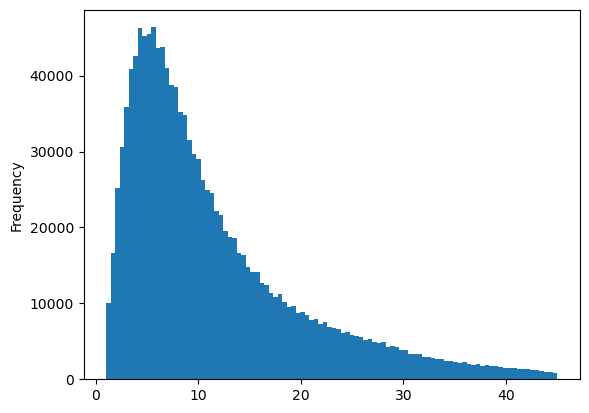

In [12]:
df_shorter = df[df.tripduration/60 <= 45]['tripduration']/60
df_shorter.plot.hist(bins=100)

In [66]:
# What is the median beeline distance travelled
gdf['distance'] = gdf.apply(lambda x: geodesic((x['start station latitude'], x['start station longitude']), (x['end station latitude'], x['end station longitude'])), axis=1)
gdf['distance']=gdf['distance'].astype(str).str[:-3].astype(float)
gdf['distance'] = gdf['distance']*1000
gdf['distance'].median()

1299.9714521791336

<AxesSubplot: xlabel='distance', ylabel='tripduration'>

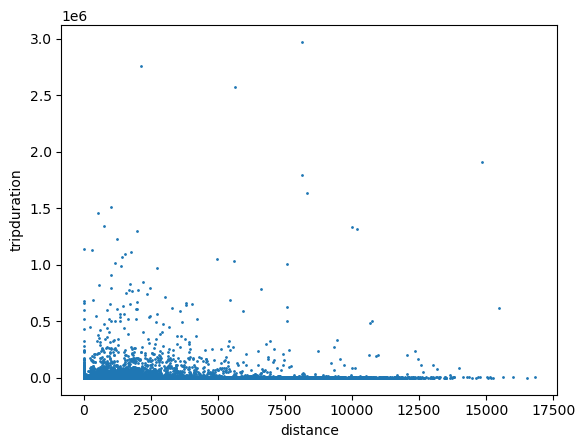

In [67]:
# 12

gdf_subset = gdf[['distance', 'tripduration']]

gdf_subset.plot.scatter(x = 'distance', y='tripduration',s=1)

In [71]:
# 13. Plot a map indicating the 10 most and least active stations.

# Get activity measure: Occurence of the station in start or stop

# Make a dataframe containing all stations and their geometries
start_stations = df[['start station id', 'start station longitude', 'start station latitude']]
end_stations =df[['end station id', 'end station longitude', 'end station latitude']]

start_stations.rename(columns={'start station id':'station_id', 'start station longitude':'lon', 'start station latitude':'lat'}, inplace=True)
end_stations.rename(columns={'end station id':'station_id', 'end station longitude':'lon', 'end station latitude':'lat'}, inplace=True)

stations = pd.concat([start_stations, end_stations])

C:\Users\adria\AppData\Local\Temp\ipykernel_8940\2967369252.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_stations.rename(columns={'start station id':'station_id', 'start station longitude':'lon', 'start station latitude':'lat'}, inplace=True)
C:\Users\adria\AppData\Local\Temp\ipykernel_8940\2967369252.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  end_stations.rename(columns={'end station id':'station_id', 'end station longitude':'lon', 'end station latitude':'lat'}, inplace=True)


In [130]:
stations_count = stations.groupby(['station_id', 'lon', 'lat']).size().to_frame('activity').reset_index()
stations_active = stations_count.nsmallest(10, 'activity')
stations_active = pd.concat([stations_active, stations_count.nlargest(10, 'activity')])

In [131]:

gdfe = gpd.GeoDataFrame(
    stations_active, geometry=gpd.points_from_xy(stations_active.lon, stations_active.lat))

In [132]:
gdfe.crs

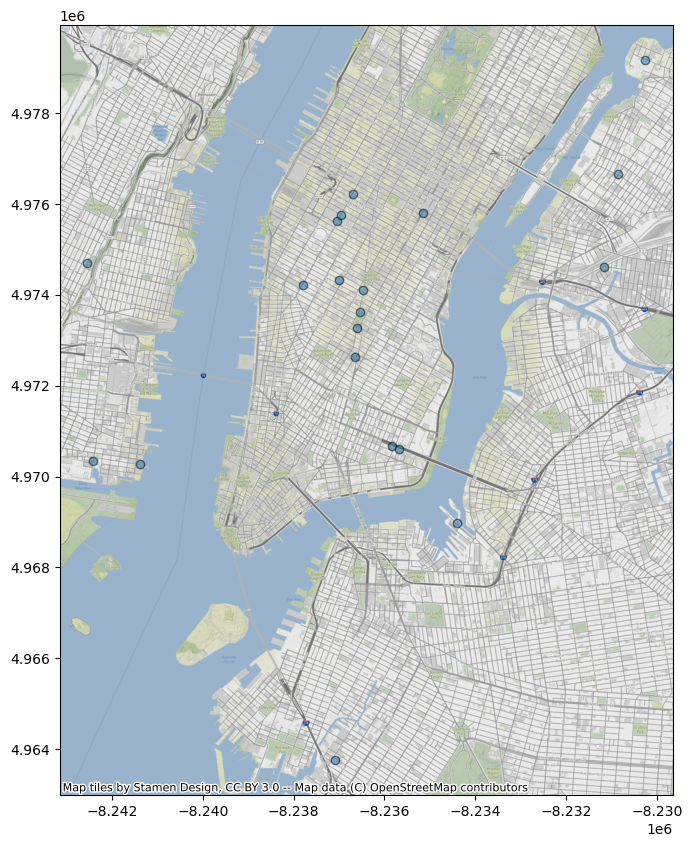

In [133]:
import contextily as cx
gdfe = gdfe.set_crs('epsg:4326')
gdfe = gdfe.to_crs(3857)
ax = gdfe.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

cx.add_basemap(ax, zoom=15)